In [2]:
import numpy as np
import sklearn
import os
import matplotlib.pyplot as plt
import cv2


# load dataset
fn = 'data.csv'
import pandas as pd
col_names = ['label', 'band1_m', 'band2_m', 'band3_m', 'band4_m']
feat_cols = col_names[1:]
df = pd.read_table( fn, delimiter=',', header=None, names=col_names )
df = sklearn.utils.shuffle( df )

# 
print( 'data:' )
print( df.head() )
print( 'value counts:' )
print( df.label.value_counts() )

data:
                label     band1_m     band2_m     band3_m     band4_m
1016    Metálica rojo  154.297181  132.434783  120.569517  125.188247
1212      Tejado rojo  129.100388  110.126891   85.089386  111.382423
586    Metálica verde  124.618297  140.007624  134.360673  118.901157
278   Metálica blanco  240.421601  253.702017  243.141184  184.692908
1101  Metálica blanco  235.309902  245.315246  229.908330  202.650923
value counts:
Metálica verde     237
Metálica blanco    210
Otros              203
Fibrocemento       202
Metálica rojo      200
Tejado rojo        196
Name: label, dtype: int64


classes: ['Fibrocemento' 'Metálica blanco' 'Metálica rojo' 'Metálica verde' 'Otros'
 'Tejado rojo']


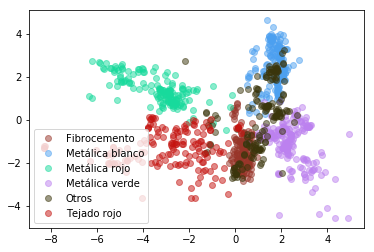

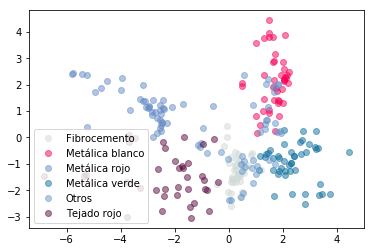

Train accuracy 0.9408817635270541%
Test accuracy 0.916%


In [8]:
from sklearn import preprocessing
X = df[ feat_cols ].values
y = df[ col_names[0] ].values
le = preprocessing.LabelEncoder()
le.fit( y )
y = le.transform( y )
print( 'classes:', le.classes_ )
#  lb = preprocessing.LabelBinarizer()
#  lb.fit( y )
#  y = lb.transform( y )
#  print( 'classes:', lb.classes_ )



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2 )



# normalization
scaler = preprocessing.StandardScaler().fit( X_train )
X_scaled = scaler.transform( X )
X_train_scaled = scaler.transform( X_train )
X_test_scaled  = scaler.transform( X_test )



# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA( n_components=4 )
lda.fit( X_train_scaled, y_train )



# visualize train set dicriminant components
X_lda = lda.transform( X_train_scaled )
#
x_DC1 = X_lda[:,0]
x_DC2 = X_lda[:,1]
for class_ in le.classes_ :
    I = y_train == le.transform([ class_ ])
    color = np.random.rand(1,3)
    color = tuple( color[0,:] )
    plt.plot( x_DC1[I], x_DC2[I], linestyle='', marker='o', color=color, alpha=.5 )
plt.legend( le.classes_ )
plt.show()

#  #
#  from sklearn.ensemble import RandomForestClassifier
#  classifier = RandomForestClassifier( max_depth=2, random_state=0 )
#  classifier.fit( X_scaled, y )
#  y_pred = classifier.predict( X_scaled )
#  from sklearn.metrics import accuracy_score
#  print('Accuracy {}%'.format( accuracy_score(y, y_pred) ))

#  from sklearn import linear_model
#  lm = linear_model.LinearRegression()
#  model = lm.fit( X_train, y_train )
#  predictions = lm.predict( X_test )



# visualize test set dicriminant components
X_lda = lda.transform( X_test_scaled )
#
x_DC1 = X_lda[:,0]
x_DC2 = X_lda[:,1]
for class_ in le.classes_ :
    I = y_test == le.transform([ class_ ])
    color = np.random.rand(1,3)
    color = tuple( color[0,:] )
    plt.plot( x_DC1[I], x_DC2[I], linestyle='', marker='o', color=color, alpha=.5 )
plt.legend( le.classes_ )
plt.show()



#  from sklearn.svm import SVC
#  clf = SVC( gamma='scale', decision_function_shape='ovo' )
#  clf.fit( X_train_scaled, y_train ) 
#  #
#  y_train_pred = clf.predict( X_train_scaled )
#  y_test_pred  = clf.predict( X_test_scaled )
#  #
#  from sklearn.metrics import accuracy_score
#  print('Train accuracy {}%'.format( accuracy_score(y_train, y_train_pred) ))
#  print('Test accuracy {}%'.format( accuracy_score(y_test, y_test_pred) ))



from sklearn.svm import SVC
clf = SVC( gamma='scale', decision_function_shape='ovo' )
X_train_lda = lda.transform( X_train_scaled )
X_test_lda  = lda.transform( X_test_scaled )
clf.fit( X_train_lda, y_train ) 
#
y_train_pred = clf.predict( X_train_lda )
y_test_pred  = clf.predict( X_test_lda )
#
from sklearn.metrics import accuracy_score
print('Train accuracy {}%'.format( accuracy_score(y_train, y_train_pred) ))
print('Test accuracy {}%'.format( accuracy_score(y_test, y_test_pred) ))

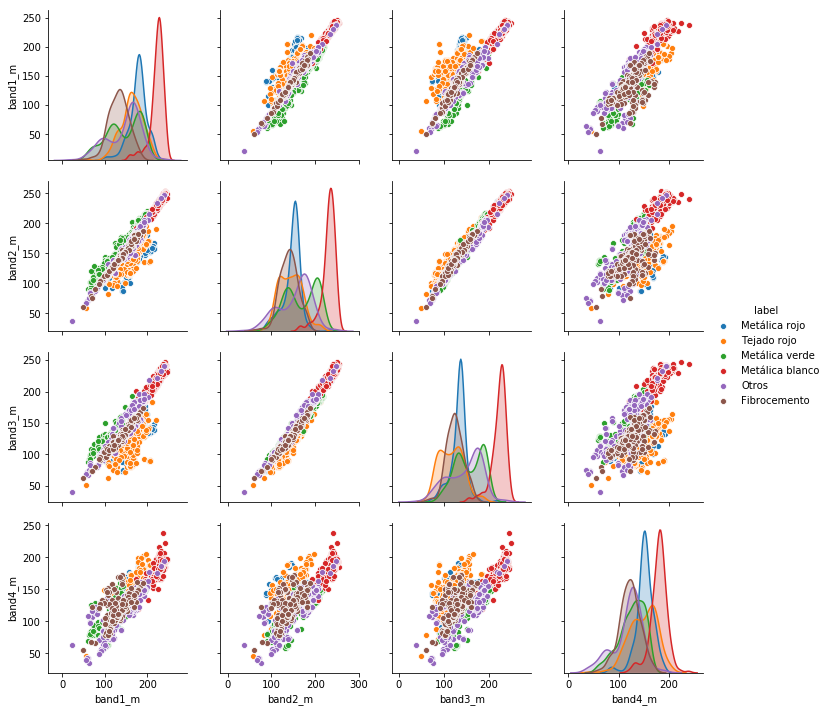

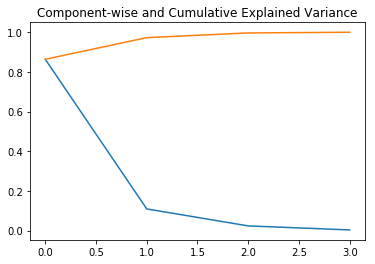

In [11]:
import seaborn as sns
sns.pairplot( df, hue='label' )
plt.show()


from sklearn.decomposition import PCA
pca = PCA( n_components=len(feat_cols) )
pca_result = pca.fit_transform( X_scaled )
plt.plot( range(4), pca.explained_variance_ratio_ )
plt.plot( range(4), np.cumsum(pca.explained_variance_ratio_) )
plt.title( 'Component-wise and Cumulative Explained Variance' )
plt.show()

In [ ]:
import glob
from osgeo import gdal
from osgeo import ogr
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2


# load shp
print( 'loading shp..' )
shp_fn = 'data2/shp/Edif_Clases.shp'
shp = ogr.Open( shp_fn , 0 ) # 0 means read-only. 1 means writeable.
layer = shp.GetLayer()
print( 'len(layer):', len(layer) )
#
data = []
for idx, feature in enumerate(layer) :
    envelope = feature.GetGeometryRef().GetEnvelope()
    xmin, xmax, ymin, ymax = envelope
    #  roi_bbox = xmin, ymax, xmax, ymin
    # extend roi
    margin = 14
    roi_bbox = xmin-margin, ymax+margin, xmax+margin, ymin-margin

    #  # dbg
    #  idxs = find_intersecting_rasters( rasters_geom, roi_bbox )
    #  if len(idxs) < 1 :
    #      assert(False), 'roi does not intersect any raster'

    #
    subraster = get_roi( filenames, rasters_geom, roi_bbox )

    # subraster_mask
    shp_idx = ogr.GetDriverByName('Memory').CreateDataSource('')
    source_layer = shp_idx.CreateLayer('states_extent')
    source_layer.CreateFeature( feature )
    subraster_mask = draw_mask( subraster, source_layer )

    #
    img = raster2img( subraster )
    mask = raster2img( subraster_mask )

    # 
    kernel = np.ones( (1+9,1+9), np.uint8 )
    #  mask2 = cv2.dilate( mask, kernel, iterations=1 )
    mask1 = mask
    mask2 = cv2.erode( mask, kernel, iterations=1 )
    img1 = np.array( img )
    img2 = np.array( img )
    I1 = mask1 == 0
    I2 = mask2 == 0
    for k in range(img.shape[2]) :
        img1[ I1, k ] = 0
        img2[ I2, k ] = 0
    # extract features in the mask
    img3 = np.array( img )
    #  img3 = img3.reshape((-1,3))
    color_m   = img3[ mask1 != 0 ].mean(axis=0)
    color_std = img3[ mask1 != 0 ].std(axis=0)
    print( feature['TIPO_CUBIE'], 'color:', color_m, color_std )
    data.append( (feature['TIPO_CUBIE'], color_m) )


print( 'data' )
for label, color in data :
    print( '{},{}'.format( label, ','.join(list(map(str,color))) ) )


In [12]:
# TODO
def get_dataset() :
    # load .shp
    
    X_files, y = ds
    X = []
    for fn in X_files :
        img = cv2.imread( fn )[..., ::-1]
        img = np.float32( img )
#         img = img[...,0]/255 + img[...,1]/255 + img[...,2]/255\n",
        X.append( img )
    X = np.stack( X, axis=0 )
    return X, y


In [ ]:
def get_pix_sz() :
    raise 'TODO'

In [ ]:
#  def get_img( size ) : # for Mask R-CNN (a layer in the img defines the labels)
#      pass

def get_img( roi_poly, bbox ) : # for classifiers (a layer in the img defines the ROI)
    img = TODO()
    return img

In [ ]:
def get_roi_bbox( poly, pix_sz, shift ) :

In [ ]:
# See: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    
    def __init__(self, polys, labels, n_classes, input_shape, batch_size=32 ):
        self.labels = labels
        self.polys = polys
        self.n_classes = n_classes
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        raise 'REVIEW'
        return int(np.floor(len(self.labels) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[ index*self.batch_size : (index+1)*self.batch_size ]
        # Generate data
        X = []
        y = []
        for k in range( self.batch_size ) :
            k2 = indexes[k]
            poly = self.polys[ k2 ]
            bbox = get_roi_bbox( poly, pix_sz, .25 )
            img = get_img( poly, bbox )
            X.append( img )
            y = append( self.labels[ k2 ] )
        X = np.stack( X, axis=0 )            
        Y = keras.utils.to_categorical( y, num_classes=self.n_classes )
        #
        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len( self.labels ))
        np.random.shuffle( self.indexes )
      
    
def create_train_generator( x_poly_train, y_train, n_classes, input_shape, batch_size=16 ) :
    n = len( y_train )
    h_pix, w_pix = input_shape[:2]
    pix_sz = get_pix_sz()
    h_wc = pix_sz * h # wc (world coords)
    w_wc = pix_sz * w # wc (world coords)
    y_delta = h_world * (np.random.rand() - .5) * .5
    x_delta = w_world * (np.random.rand() - .5) * .5
    #
    
    train_datagen = ImageDataGenerator(
            rescale=1,
            shear_range=0,
            zoom_range=0,
            horizontal_flip=True)

    train_generator = TODO( train_datagen, batch_size=32 )
    
    for x_batch, y_batch in datagen.flow( x_train, y_train ):
        model.fit(x_batch, y_batch)
        batches += 1
        if batches >= len(x_train) / 32:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break    
    
    #
    for poly in x_poly_train :
        centroid_x, centroid_y = TODO( poly )
        x_min = centroid_x - w_wc/2 + x_delta
        x_max = centroid_x + w_wc/2 + x_delta
        y_min = centroid_y - h_wc/2 + y_delta
        y_max = centroid_y + h_wc/2 + y_delta
        bbox = x_min, y_max, x_max, y_min
        img = get_img( poly, bbox )
    #
    raise 'TODO'
    yield img, 
    
    

In [18]:
def create_classifier_model( input_shape, n_classes ) :

    from keras.models import Model
    from keras.layers import Cropping2D, Lambda, Reshape
    from keras.layers import Conv2D, MaxPooling2D
    from keras.layers import Input, Dense, ELU, Activation, Flatten
    from keras.layers import Dropout, BatchNormalization

    from keras import backend as K
    print('input_shape', input_shape)
    input_ = Input( shape=input_shape )
#     hidden = Lambda( lambda x: x[:,:,:,0]/3 + x[:,:,:,1]/3 + x[:,:,:,2]/3 )( input_ )\n",
#     hidden = Reshape( (*input_shape[:-1], 1) )( hidden )\n",
    hidden = input_
    hidden = BatchNormalization()( hidden )
#     hidden = Cropping2D( cropping=((0,0),(0,0)) )( input_ )
    with K.name_scope('Layer1') :
        hidden = Conv2D( 16, 3 )( hidden )
        print( 'Layer 1:', hidden.shape )
        hidden = MaxPooling2D( pool_size=(2, 2) )( hidden )
        hidden = ELU()( hidden )
    with K.name_scope('Layer2') :
        hidden = Conv2D(24, 3)( hidden )
        print( 'Layer 2:', hidden.shape )
        hidden = MaxPooling2D(pool_size=(2, 2))( hidden )
        hidden = ELU()( hidden )
    with K.name_scope('Layer3') :
        hidden = Conv2D(36, 3)( hidden )
        print( 'Layer 3:', hidden.shape )
        hidden = MaxPooling2D(pool_size=(2, 2))( hidden )
        hidden = ELU()( hidden )
    hidden = Dropout(.5)( hidden )
    hidden = Flatten()( hidden )
    with K.name_scope('Layer4') :
        hidden = Dense(512)( hidden )
        hidden = ELU()( hidden )
    #  with K.name_scope('Layer5'):\n",
    #      model.add(Dense(512))\n",
    #      #  model.add(BatchNormalization())\n",
    #      #  model.add(Dropout(.3))\n",
    #      model.add(ELU()) # model.add(Activation('relu'))\n",
    with K.name_scope('Output') :
        #  model.add(Dropout(.3))
        hidden = Dense(n_classes)( hidden )
        predictions = Activation('softmax')( hidden )
    model = Model(inputs=input_, outputs=predictions)
    return model
# dbg
input_shape = (416,416,3)
n_classes = 4
model = create_classifier_model( input_shape, n_classes )

input_shape (416, 416, 3)
Layer 1: (?, 414, 414, 16)
Layer 2: (?, 205, 205, 24)
Layer 3: (?, 100, 100, 36)


In [13]:
def train():
    from keras.optimizers import Adam
    from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

    # model meta
    input_shape = 416, 416, 4
    #  img_size = input_shape[:2][::-1]
    
    # reproducible results :)
    np.random.seed(0)
    
    # load dataset
    x_urls, y = get_dataset()
    #  input_shape = X_train[0,...].shape
    n_classes = np.unique( y )

    # create train and test datasets
    from sklearn.model_selection import train_test_split
    x_poly_train, x_poly_test, y_train, y_test = train_test_split( x_urls, y, test_size=0.2, random_state=0 )
    
    # create model
    model = create_classifier_model( input_shape, n_classes )

    # train model

    # training meta
    batch_size = 32
    optimizer = Adam( lr=1e-4 )
    # callbacks
    log_dir = '/tmp/log_dir'
    logging = TensorBoard( log_dir=log_dir )
    reduce_lr = ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=2, verbose=1 )
    early_stopping = EarlyStopping( monitor='val_loss', min_delta=0, patience=5, verbose=1 )

    # generators
    train_generator      = DataGenerator( x_poly_train, y_train, n_classes, input_shape, batch_size )
    validation_generator = DataGenerator( x_poly_test,  y_test,  n_classes, input_shape, batch_size )
    
    # train
    model.compile( loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'] )
    history = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=validation_generator,
            validation_steps=max(1, num_val//batch_size),
            epochs=30,
            initial_epoch=0,
            callbacks=[logging, reduce_lr, early_stopping]
            )

    # save
    fn = '/tmp/model.h5'
    model.save( fn )

    # eval model
    # prepare test data for evaluation
    X_test = [ get_img( poly, input_shape ) for poly in x_poly_test ]
    X_test = np.stack( X_test, axis=0 )
    from keras.utils import np_utils        
    Y_test = np_utils.to_categorical( y_test, n_classes )
    # eval
    score = model.evaluate( X_test, Y_test, verbose=1 )
    print('Test score (loss?):', score[0])
    print('Test accuracy:', score[1])
#
train()